In [1]:
from scipy.ndimage.measurements import label as bwlabel
from skimage.measure import regionprops
from skimage.color import label2rgb
from pylab import *


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 16

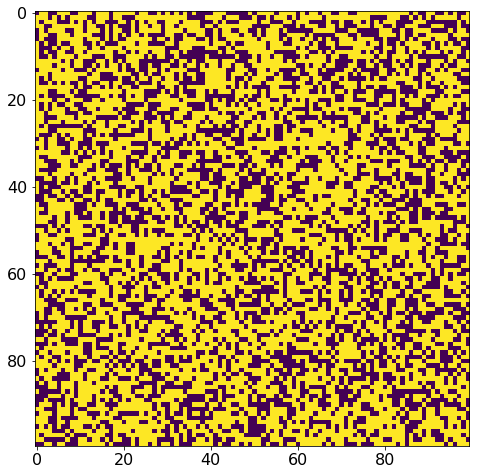

In [3]:
L = 100

r = rand(L, L)
p = 0.6

z = r < p
lw, num = bwlabel(z)

imshow(z)
show()

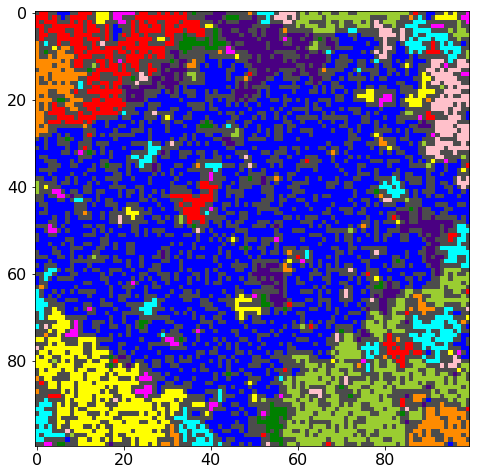

In [4]:
img = label2rgb(lw, bg_label=0, bg_color=[0.3, 0.3, 0.3])
imshow(img)
show()

In [5]:
s = regionprops(lw)
area = [s[i]['area'] for i in range(len(s))]
bbox = [s[i]['bbox'] for i in range(len(s))]


In [6]:
print(area[:10])
print(bbox[:10])

[293, 4, 8, 9, 1, 8, 1, 7, 10, 64]
[(0L, 0L, 26L, 39L), (0L, 5L, 2L, 8L), (0L, 14L, 3L, 17L), (0L, 18L, 3L, 23L), (0L, 36L, 1L, 37L), (0L, 39L, 3L, 44L), (0L, 49L, 1L, 50L), (0L, 51L, 3L, 55L), (0L, 55L, 3L, 60L), (0L, 60L, 5L, 86L)]


In [7]:
from numba import jit

In [8]:
%%time

def percolation_matrix(p, Lx, Ly=None):
    Ly = Lx if Ly is None else Ly 
    r = rand(L, L)
    z = r < p
    lw, num = bwlabel(z)
    return lw, num
            

def probs_calculate(ps, Lx, Ly=None, simulation_per_p=10):
    Ly = Lx if Ly is None else Ly
    total_area = Lx*Ly
    
    P = zeros(len(ps))
    Pie = zeros(len(ps))

    for i, pi in enumerate(ps):
        simulation_i = 0

        while simulation_per_p > simulation_i:
            lw, num = percolation_matrix(pi, Lx, Ly)
            cluster_infos = regionprops(lw)
            bboxs = array([cluster_infos[k]['bbox'] for k in range(len(cluster_infos))]).astype(int)
            
            spanning = False
            if len(bboxs) > 0:
                jxs = argwhere(bboxs[:, 2] - bboxs[:, 0] >= Lx)  # indecies where Xmax - Xmin >= Lx
                jys = argwhere(bboxs[:, 3] - bboxs[:, 1] >= Ly)  # indecies where Ymax - Ymin >= Ly
                js = unique(vstack((jxs, jys)))
                
                if len(js) > 0:
                    P[i] += sum([cluster_infos[j]['area'] for j in js])
                spanning = True if len(jxs) + len(jys) > 0 else False
                    
            Pie[i] += int(spanning)
            simulation_i += 1

    Pie[:] /= simulation_per_p
    P[:] /= simulation_per_p * total_area
    return P, Pie


number_of_p = 100 
ps = [float(i)/number_of_p for i in range(number_of_p)]

Lx = 100
Ly = 100

simulation_per_p = 100

P, Pie = probs_calculate(ps, Lx, Ly, simulation_per_p)

Wall time: 45.8 s


In [9]:
import seaborn as sns
sns.set_palette("PuBuGn_d")
sns.set()
sns.set_context("poster")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

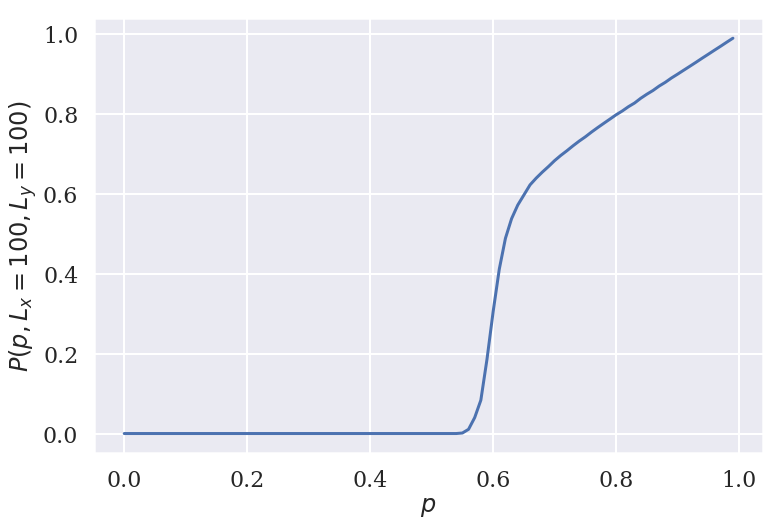

In [10]:
lplot = sns.lineplot(ps, P, lw=3)
lplot.set_xlabel(r"$p$")
lplot.set_ylabel(r"$P(p, L_x={}, L_y={})$".format(Lx, Ly))
savefig("probabil-100-1.eps")
show()

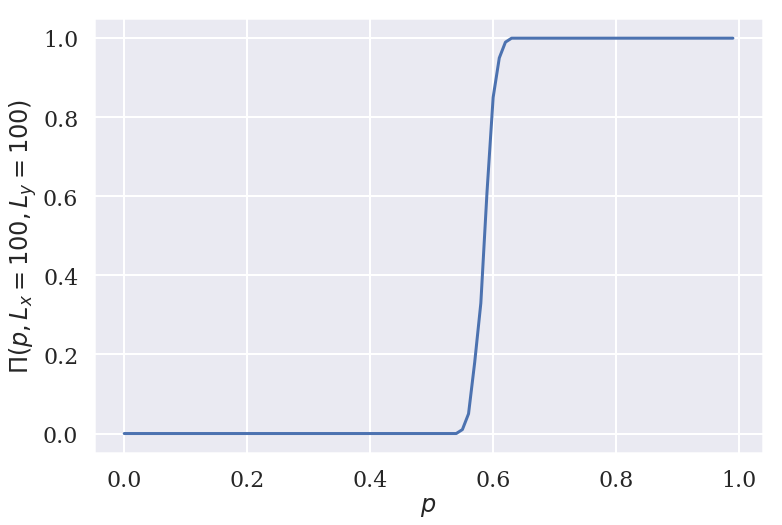

In [11]:
lplot = sns.lineplot(ps, Pie, lw=3)
lplot.set_xlabel("$p$")
lplot.set_ylabel(r"$\Pi(p, L_x={}, L_y={})$".format(Lx, Ly))
savefig("probabil-100-2.eps")
show()

In [12]:
%%time

Ls = [2**i for i in range(1, 8)]
Ps = []
Pies = []

for L in Ls:
    P, Pie = probs_calculate(ps, L, simulation_per_p=1000)
    Ps.append(P)
    Pies.append(Pie)

Wall time: 19min 15s


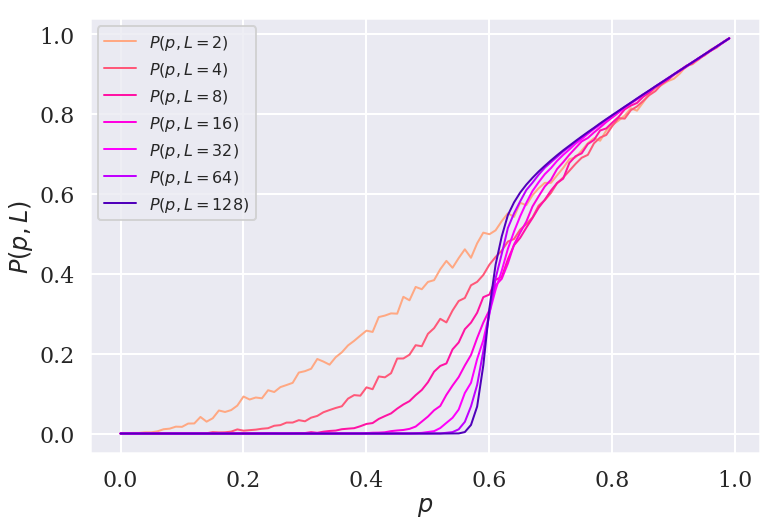

In [13]:
with sns.cubehelix_palette(hue=5, n_colors=7, gamma=1):
    for i, P in enumerate(Ps):
        lplot = sns.lineplot(ps, P, lw=2, label=r'$P(p, L={})$'.format(Ls[i]))

    lplot.set_xlabel(r"$p$")
    lplot.set_ylabel(r"$P(p, L)$")
    legend(fontsize=16)
    savefig("problem-b-3.eps")
    show()

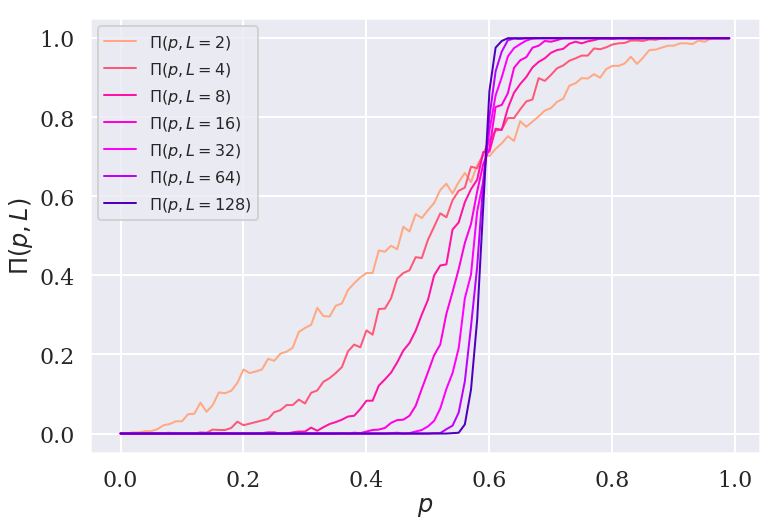

In [14]:
with sns.cubehelix_palette(hue=5, n_colors=7, gamma=1):
    for i, Pie in enumerate(Pies):
        lplot = sns.lineplot(ps, Pie, lw=2, label=r'$\Pi(p, L={})$'.format(Ls[i]))

    lplot.set_xlabel(r"$p$")
    lplot.set_ylabel(r"$\Pi(p, L)$")
    legend(fontsize=16)
    savefig("problem-b-4.eps")
    show()

Alpha = 1.22779810246, Beta = 0.261569229859


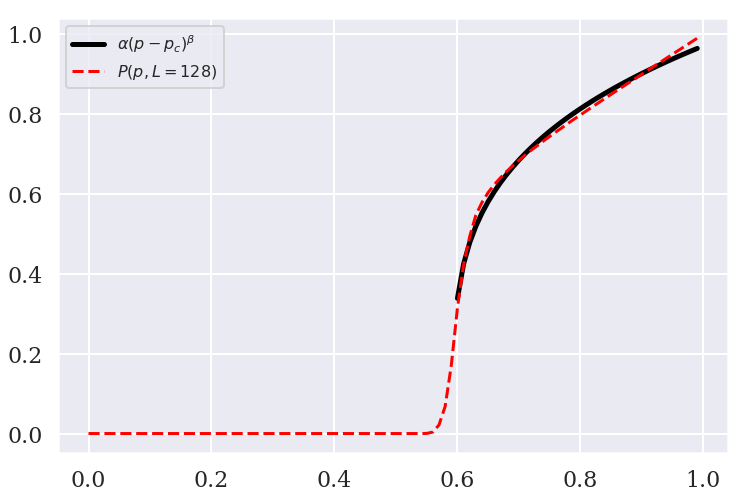

In [15]:
P = array(Ps[-1])
ps = array(ps)
pc = 0.59275

psc = ps[pc < ps]
Pc = P[pc < ps]

beta, log_alpha  = polyfit(log(psc - pc), log(Pc), 1)
alpha = exp(log_alpha)

print("Alpha = {}, Beta = {}".format(alpha, beta))

sns.lineplot(psc, alpha*(psc - pc)**beta, label=r"$\alpha (p - p_c)^\beta$", color='black', lw=5)
s = plot(ps, P, '--', color='red', label=r"$P(p, L={})$".format(Ls[-1]))

lplot.set_xlabel(r"$p$")
lplot.set_ylabel(r"$P(p, L)$")
legend(fontsize=16)
show()